In [1]:
!wget https://uofi.box.com/shared/static/5tp2foxit52byt2zh9eqnnd8oi3ac9ym.zip

--2023-10-18 17:57:32--  https://uofi.box.com/shared/static/5tp2foxit52byt2zh9eqnnd8oi3ac9ym.zip
Resolving uofi.box.com (uofi.box.com)... 74.112.186.144
Connecting to uofi.box.com (uofi.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/5tp2foxit52byt2zh9eqnnd8oi3ac9ym.zip [following]
--2023-10-18 17:57:33--  https://uofi.box.com/public/static/5tp2foxit52byt2zh9eqnnd8oi3ac9ym.zip
Reusing existing connection to uofi.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://uofi.app.box.com/public/static/5tp2foxit52byt2zh9eqnnd8oi3ac9ym.zip [following]
--2023-10-18 17:57:33--  https://uofi.app.box.com/public/static/5tp2foxit52byt2zh9eqnnd8oi3ac9ym.zip
Resolving uofi.app.box.com (uofi.app.box.com)... 74.112.186.144
Connecting to uofi.app.box.com (uofi.app.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcl

In [2]:
!unzip /content/5tp2foxit52byt2zh9eqnnd8oi3ac9ym.zip

Streaming output truncated to the last 5000 lines.
  inflating: intel/seg_train/mountain/7539.jpg  
  inflating: intel/seg_train/mountain/7551.jpg  
  inflating: intel/seg_train/mountain/7560.jpg  
  inflating: intel/seg_train/mountain/7565.jpg  
  inflating: intel/seg_train/mountain/7578.jpg  
  inflating: intel/seg_train/mountain/7581.jpg  
  inflating: intel/seg_train/mountain/7586.jpg  
  inflating: intel/seg_train/mountain/7647.jpg  
  inflating: intel/seg_train/mountain/7652.jpg  
  inflating: intel/seg_train/mountain/7654.jpg  
  inflating: intel/seg_train/mountain/7662.jpg  
  inflating: intel/seg_train/mountain/767.jpg  
  inflating: intel/seg_train/mountain/7672.jpg  
  inflating: intel/seg_train/mountain/7679.jpg  
  inflating: intel/seg_train/mountain/7681.jpg  
  inflating: intel/seg_train/mountain/7693.jpg  
  inflating: intel/seg_train/mountain/7695.jpg  
  inflating: intel/seg_train/mountain/7698.jpg  
  inflating: intel/seg_train/mountain/7700.jpg  
  inflating: intel/

### Load Libraries

In [3]:
import os
import shutil
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2D, Dense, MaxPooling2D, Flatten, BatchNormalization, Input, DepthwiseConv2D
from tensorflow.keras.layers import SeparableConv2D, Add, Dropout
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetV2B2
from sklearn.metrics import confusion_matrix, classification_report


# Define the directory paths for train and test sets
train_dir = '/content/intel/seg_train'
test_dir = '/content/intel/seg_test'
val_dir = '/content/intel/seg_val'

In [4]:
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [5]:
batch_size = 32
num_classes = 6
image_size = (150, 150)
input_shape = (150,150,3)
epochs = 10
seed = 42

Del a Damage Image

In [6]:
# Path of the image
image_path = '/content/intel/seg_train/buildings/6814.jpg'

# Check if the file exists before attempting to delete it
if os.path.exists(image_path):
    os.remove(image_path)
    print(f'The image {image_path} has been deleted.')
else:
    print(f'The image {image_path} does not exist or could not be deleted.')

The image /content/intel/seg_train/buildings/6814.jpg has been deleted.


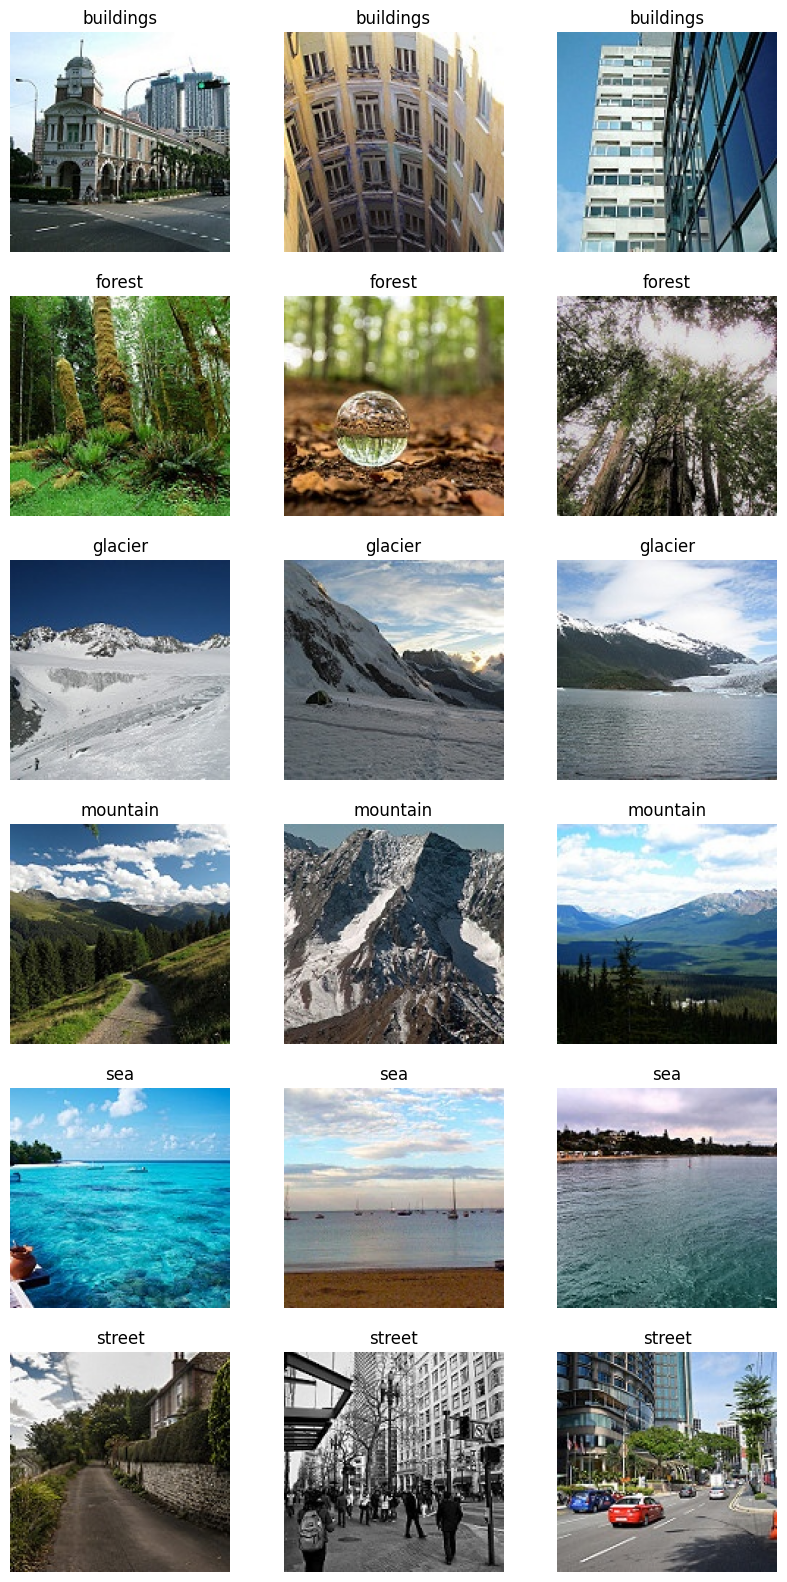

In [7]:
# Create a figure with a grid layout to display images
fig, axes = plt.subplots(len(class_names), 3, figsize=(10, 20))

for i, class_name in enumerate(class_names):
    class_dir = os.path.join(train_dir, class_name)
    image_files = os.listdir(class_dir)[:3]  # Display the first 3 images from each class
    for j, image_file in enumerate(image_files):
        image_path = os.path.join(class_dir, image_file)
        image = cv2.imread(image_path)  # Load the image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        axes[i, j].imshow(image)
        axes[i, j].set_title(class_name)
        axes[i, j].axis("off")

plt.show()

# Count numbers of images in Train and Test

In [8]:
# Initialize dictionaries to store counts
train_counts = {}
test_counts = {}

# Count the number of images in each category for the train set
for category in class_names:
    train_counts[category] = len(os.listdir(os.path.join(train_dir, category)))

# Count the number of images in each category for the test set
for category in class_names:
    test_counts[category] = len(os.listdir(os.path.join(test_dir, category)))

print("Train Set Image Counts:")
print(train_counts)

print("\nTest Set Image Counts:")
print(test_counts)

Train Set Image Counts:
{'buildings': 2190, 'forest': 2271, 'glacier': 2404, 'mountain': 2512, 'sea': 2274, 'street': 2382}

Test Set Image Counts:
{'buildings': 437, 'forest': 474, 'glacier': 553, 'mountain': 525, 'sea': 510, 'street': 501}


# Create 20% Validation Data

In [9]:
# Create the validation directory if it doesn't exist
if not os.path.exists(val_dir):
    os.makedirs(val_dir)

# Define the percentage to move to the validation set (20%)
validation_percentage = 0.2

# Move 20% of the images from the training set to the validation set for each category
for category in class_names:
    category_train_dir = os.path.join(train_dir, category)
    category_val_dir = os.path.join(val_dir, category)

    if not os.path.exists(category_val_dir):
        os.makedirs(category_val_dir)

    # List all image files in the category's training directory
    category_images = os.listdir(category_train_dir)

    # Calculate the number of images to move to the validation set
    num_validation_samples = int(len(category_images) * validation_percentage)

    # Randomly select and move the images
    random.shuffle(category_images)
    for image_filename in category_images[:num_validation_samples]:
        source = os.path.join(category_train_dir, image_filename)
        destination = os.path.join(category_val_dir, image_filename)
        shutil.move(source, destination)

In [10]:
val_counts = {}

# Count the number of images in each category for the val set
for category in class_names:
    val_counts[category] = len(os.listdir(os.path.join(val_dir, category)))

print("Val Set Image Counts:")
print(val_counts)

Val Set Image Counts:
{'buildings': 438, 'forest': 454, 'glacier': 480, 'mountain': 502, 'sea': 454, 'street': 476}


# Create tf.data.Datasets for the train and validation

In [11]:
def create_label_mapping(class_names):
    return tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(class_names, tf.range(len(class_names))),
        default_value=-1
    )

def preprocess_image(image):
    image = tf.clip_by_value(image, 0, 1)
    return image

def load_and_preprocess_image(file_path, label):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)
    image = preprocess_image(image)
    return image, label

def create_dataset(data_dir, batch_size, class_names):
    label_to_int = create_label_mapping(class_names)

    files = tf.data.Dataset.list_files(data_dir + '/*/*')
    labels = files.map(lambda x: tf.strings.split(x, os.path.sep)[-2])
    labels = labels.map(lambda x: label_to_int.lookup(x))
    labels = labels.map(lambda x: tf.one_hot(x, len(class_names)))

    dataset = tf.data.Dataset.zip((files, labels))
    dataset = dataset.map(lambda x, y: load_and_preprocess_image(x, y))
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

# Create training and validation datasets
train_datasets = create_dataset(train_dir, batch_size, class_names)
val_datasets = create_dataset(val_dir, batch_size, class_names)

In [12]:
# Check the shape of the first batch in the training dataset
for batch in train_datasets.take(1):
    images, labels = batch
    print("Training Data Shape - Images:", images.shape)
    print("Training Data Shape - Labels:", labels.shape)

# Check the shape of the first batch in the validation dataset
for batch in val_datasets.take(1):
    images, labels = batch
    print("Validation Data Shape - Images:", images.shape)
    print("Validation Data Shape - Labels:", labels.shape)

Training Data Shape - Images: (32, 150, 150, 3)
Training Data Shape - Labels: (32, 6)
Validation Data Shape - Images: (32, 150, 150, 3)
Validation Data Shape - Labels: (32, 6)


# 1. CNN Model

In [13]:
# Define the CNN model
model_1 = Sequential([
    Conv2D(4, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(8, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model_1.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model_1.summary()

# Train the model on the training dataset and validate on the validation dataset
history_1 = model_1.fit(train_datasets, epochs=epochs, validation_data=val_datasets, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 4)       112       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 4)         0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 21904)             0         
                                                                 
 dense (Dense)               (None, 8)                 175240    
                                                                 
 dense_1 (Dense)             (None, 6)                 54        
                                                                 
Total params: 175406 (685.18 KB)
Trainable params: 175406 (685.18 KB)
Non-trainable params: 0 (0.00 Byte)
________________

### Plot the Learning Curves

In [14]:
def plot_data(history):
  # Plot learning curves
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')

  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(loc='upper right')

  return plt.show()

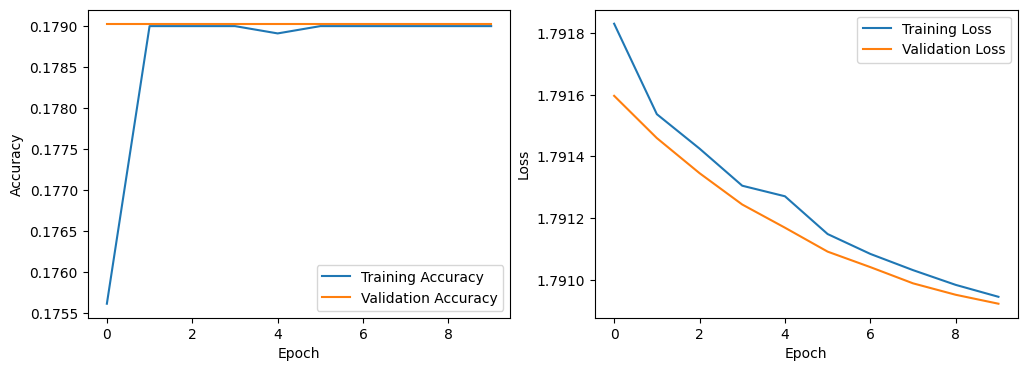

In [15]:
plot_data(history_1)

# 2. CNN Model 

In [16]:
# Define the CNN model
model_2 = Sequential([
    Conv2D(4, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(2, 2),
    Conv2D(8, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model_2.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model_2.summary()

# Train the model on the training dataset and validate on the validation dataset
history_2 = model_2.fit(train_datasets, epochs=epochs, validation_data=val_datasets, verbose=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 148, 148, 4)       112       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 74, 74, 4)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 72, 72, 8)         296       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 36, 36, 8)         0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 10368)             0         
                                                                 
 dense_2 (Dense)             (None, 16)               

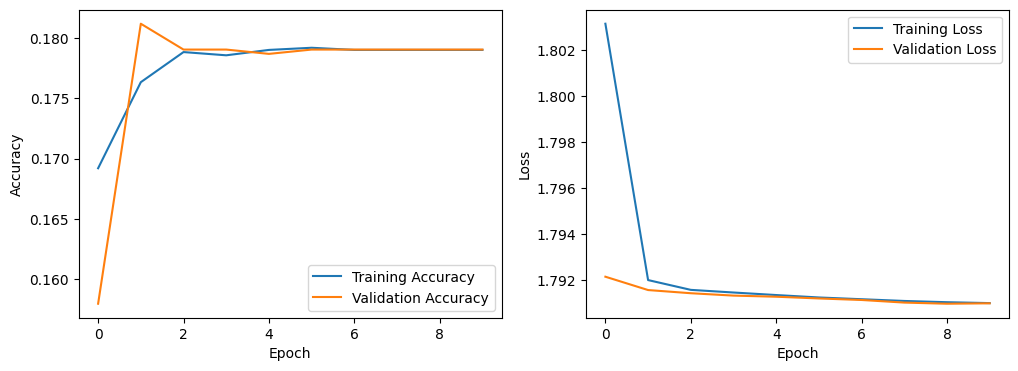

In [17]:
plot_data(history_2)

# 3. CNN Model

In [18]:
input_layer = Input(shape=input_shape)

# Initial depth-wise separable convolution
x = DepthwiseConv2D(4, (5, 5), activation='relu', padding='same')(input_layer)
x = BatchNormalization()(x)

# Residual blocks
for _ in range(3):
    residual = x
    x = SeparableConv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    # Adjust the depth of the residual tensor
    residual = Conv2D(8, (1, 1), padding='same')(residual)

    x = Add()([x, residual])  # Residual connection

# Max-pooling layer
x = MaxPooling2D(2, 2)(x)

# Fully connected layers
x = GlobalAveragePooling2D()(x)
x = Dense(8, activation='relu')(x)
output_layer = Dense(num_classes, activation='softmax')(x)

# Create the model
model_3 = Model(input_layer, output_layer)

# Compile the model
model_3.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model_3.summary()

# Train the model
history_3 = model_3.fit(train_datasets, epochs=epochs, validation_data=val_datasets, verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 depthwise_conv2d (Depthwis  (None, 30, 30, 3)            51        ['input_1[0][0]']             
 eConv2D)                                                                                         
                                                                                                  
 batch_normalization (Batch  (None, 30, 30, 3)            12        ['depthwise_conv2d[0][0]']    
 Normalization)                                                                                   
                                                                                              

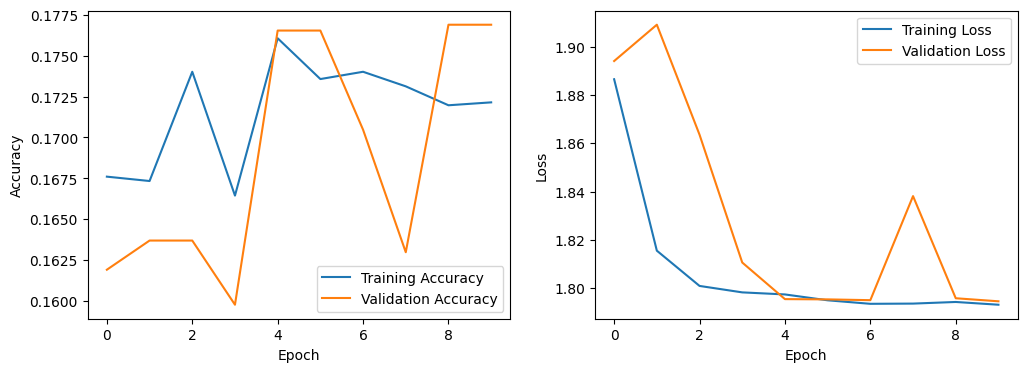

In [19]:
plot_data(history_3)

### Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)
val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical', 
        shuffle=False)

In [20]:
# Convert the DirectoryIterator to a TensorFlow dataset
train_dataset_tf = tf.data.Dataset.from_generator(
      lambda: train_generator,
      output_signature=(
          tf.TensorSpec(shape=(None, *image_size, 3), dtype=tf.float32),
          tf.TensorSpec(shape=(None, 6), dtype=tf.float32)))

train_dataset = train_dataset_tf.prefetch(buffer_size=tf.data.AUTOTUNE)

val_dataset_tf = tf.data.Dataset.from_generator(
      lambda: val_generator,
      output_signature=(
          tf.TensorSpec(shape=(None, *image_size, 3), dtype=tf.float32),
          tf.TensorSpec(shape=(None, 6), dtype=tf.float32)))

val_dataset = val_dataset_tf.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 11229 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [21]:
# Check the shape of data generated by the train_generator
for images, labels in train_dataset:
    print("Training Data Shape - Images:", images.shape, " Labels:", labels.shape)
    break  # To break the loop after printing the shape of the first batch

# Check the shape of data generated by the validation_generator
for images, labels in val_dataset:
    print("Validation Data Shape - Images:", images.shape, " Labels:", labels.shape)
    break  # To break the loop after printing the shape of the first batch

Training Data Shape - Images: (32, 150, 150, 3)  Labels: (32, 6)
Validation Data Shape - Images: (32, 150, 150, 3)  Labels: (32, 6)


In [22]:
total_samples_train = 11229 // batch_size
total_samples_val = 2804 // batch_size

# 4. CNN Model

In [23]:
# Define the CNN model
model_4 = Sequential([
    Conv2D(4, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(2, 2),
    Conv2D(8, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model_4.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model_4.summary()

# Train the model on the training dataset and validate on the validation dataset
history_4 = model_4.fit(train_dataset, epochs=epochs, validation_data=val_dataset, verbose=1,
                        steps_per_epoch=total_samples_train, validation_steps=total_samples_val)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 4)       112       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 74, 74, 4)         0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 21904)             0         
                                                                 
 dense_6 (Dense)             (None, 8)                 175240    
                                                                 
 dense_7 (Dense)             (None, 6)                 54        
                                                                 
Total params: 175406 (685.18 KB)
Trainable params: 175406 (685.18 KB)
Non-trainable params: 0 (0.00 Byte)
______________

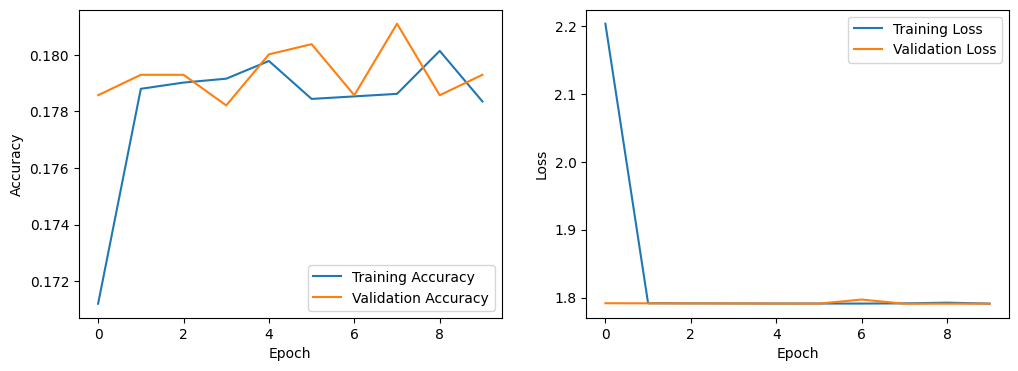

In [24]:
plot_data(history_4)

After data augmentation, there's significant improvement in training and validation accuracies compared to the previous models. The accuracy increases during training, and the model seems to be learning the task better. The training and validation losses are decreasing over the epochs, indicating that the model is making progress. While there's no clear sign of overfitting, it's important to monitor the model's performance on new data to ensure generalization.

# EfficientNetV2B2 Model

In [25]:
base_model = EfficientNetV2B2(weights='imagenet', include_top=False, input_shape=input_shape)
# Freeze the layers of the base model
for layer in base_model.layers[:-20]:
    layer.trainable = False

model_5 = Sequential([base_model,
                      GlobalAveragePooling2D(),
                      Flatten(),
                      Dense(8,activation='relu'),
                      Dense(num_classes,activation='softmax'),])

# Compile the model
model_5.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model_5.summary()

# Train the model
history_5 = model_5.fit(train_dataset, steps_per_epoch=total_samples_train, validation_data=val_dataset,
    validation_steps=total_samples_val, epochs=epochs)

35839040/35839040 [==============================] - 3s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b2 (Functio  (None, 5, 5, 1408)        8769374   
 nal)                                                            
                                                                 
 global_average_pooling2d_1  (None, 1408)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_3 (Flatten)         (None, 1408)              0         
                                                                 
 dense_8 (Dense)             (None, 8)                 11272     
                                                                 
 dense_9 (Dense)             (None, 6)                 54        
                                                       

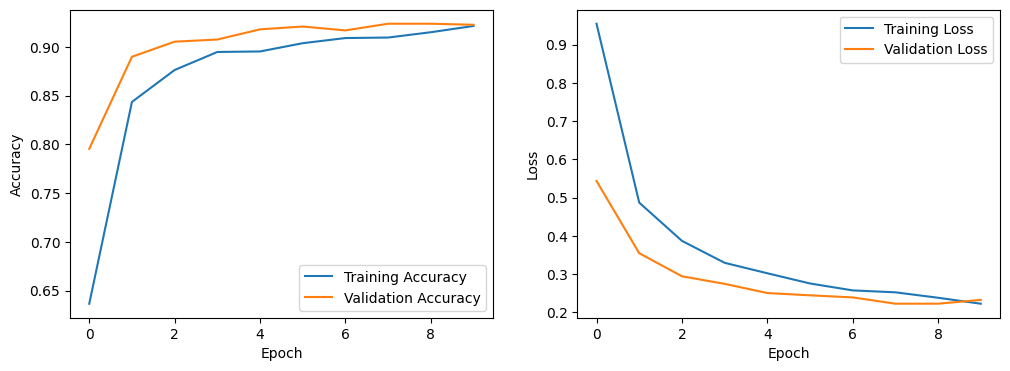

In [40]:
plot_data(history_5)

# Test EfficientNetV2B2 Model

In [41]:
test_datagen = val_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Convert the DirectoryIterator to a TensorFlow dataset
test_dataset_tf = tf.data.Dataset.from_generator(
    lambda: test_datagen,
    output_signature=(
        tf.TensorSpec(shape=(None, *image_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 6), dtype=tf.float32)
    )
)

# Use the prefetch method with the TensorFlow dataset
test_dataset = test_dataset_tf.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 3000 images belonging to 6 classes.


In [28]:
test_steps = 3000//batch_size

In [29]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model_5.evaluate(test_dataset, steps=test_steps)

# Print the test accuracy
print("Test accuracy: {:.2%}".format(test_accuracy))

93/93 [==============================] - 20s 210ms/step - loss: 0.2104 - accuracy: 0.9244
Test accuracy: 92.44%


In [42]:
# Use model.predict to get predicted probabilities
predicted_probabilities = model_5.predict(test_dataset, steps=test_steps)

93/93 [==============================] - 20s 218ms/step


In [43]:
# Get the predicted labels (class indices) for each image
predicted_labels = np.argmax(predicted_probabilities, axis=1)

In [44]:
# Initialize empty lists to collect true labels and predicted labels
true_class_indices = []
predicted_class_indices = []
total_images = 3000
processed_images = 0
# Iterate through the test dataset to collect true and predicted labels
for images, labels in test_dataset:
    batch_size = min(batch_size, total_images - processed_images)
    predictions = model_5.predict(images)
    true_class_indices.extend(tf.argmax(labels, axis=1).numpy())
    predicted_class_indices.extend(tf.argmax(predictions, axis=1).numpy())
    processed_images += batch_size

    if processed_images >= total_images:
        break

1/1 [==============================] - 0s 108ms/step


## Confusion Matrix

In [45]:
# Calculate the confusion matrix
confusion = confusion_matrix(true_class_indices, predicted_class_indices)
print("Confusion Matrix:")
print(confusion)

Confusion Matrix:
[[396   2   0   0   2  37]
 [  0 471   0   2   1   0]
 [  1   3 474  60  14   1]
 [  1   1  48 465   9   1]
 [  4   1   7  12 486   0]
 [ 28   0   0   1   5 467]]


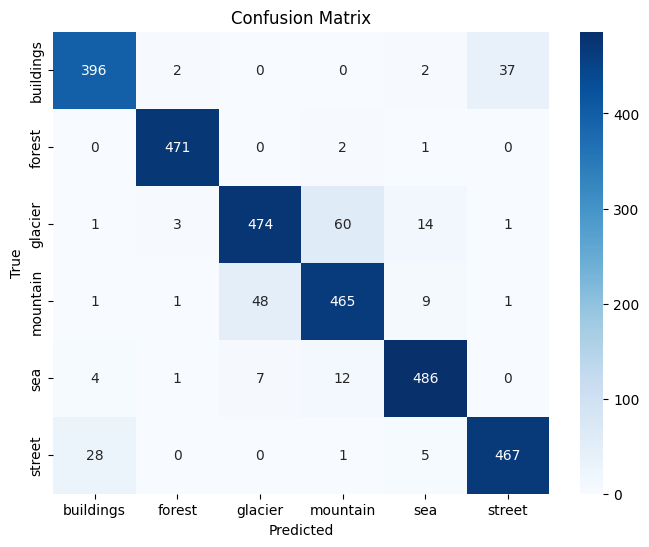

In [47]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Classification Report

In [46]:
report = classification_report(true_class_indices, predicted_class_indices, target_names=class_names)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

   buildings       0.92      0.91      0.91       437
      forest       0.99      0.99      0.99       474
     glacier       0.90      0.86      0.88       553
    mountain       0.86      0.89      0.87       525
         sea       0.94      0.95      0.95       510
      street       0.92      0.93      0.93       501

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000



# Misclassification Images

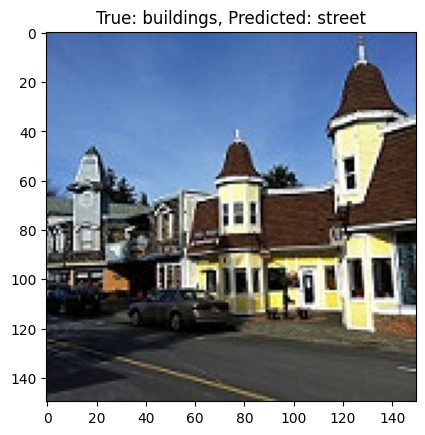

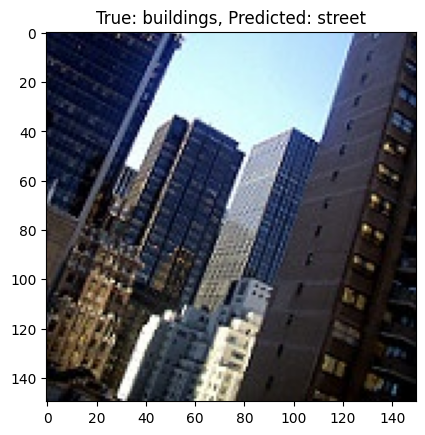

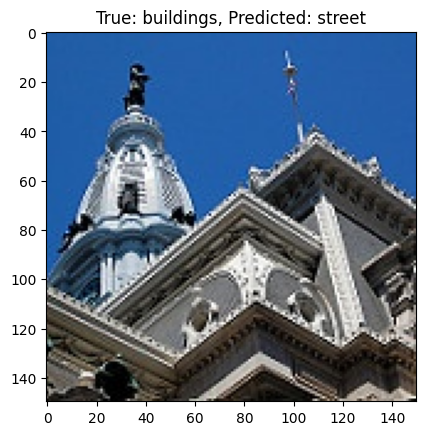

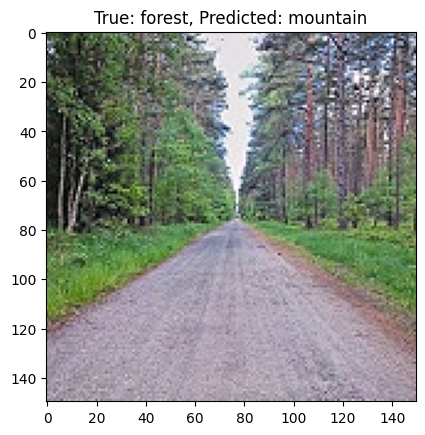

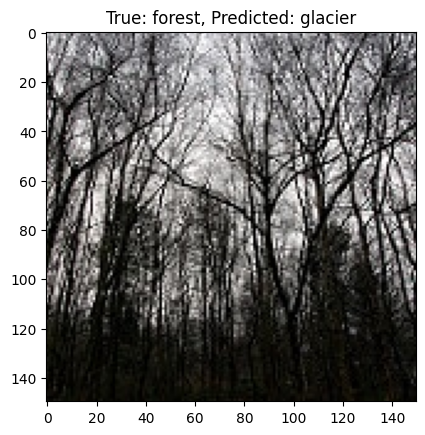

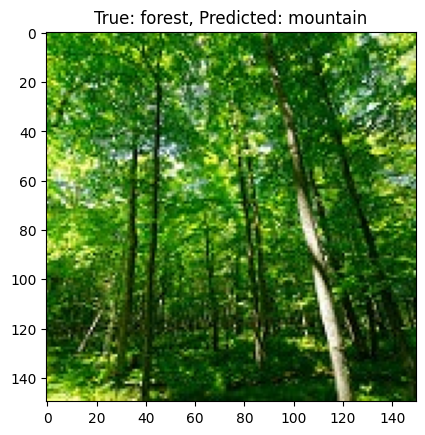

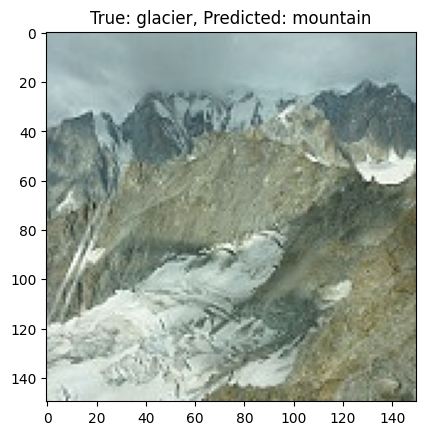

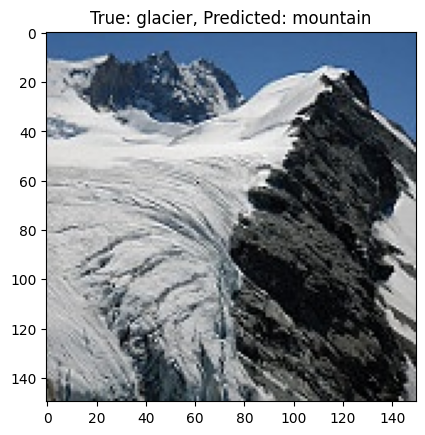

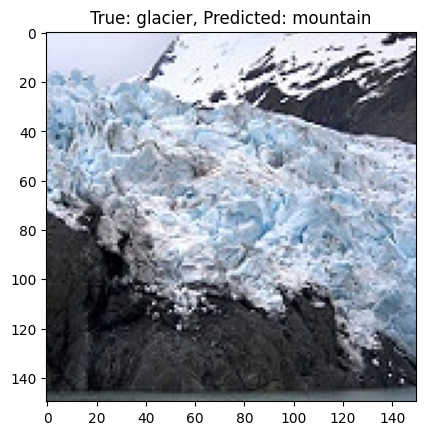

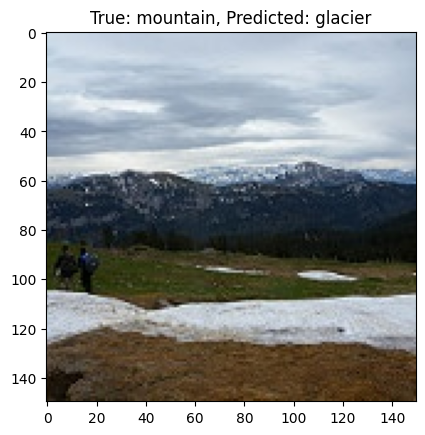

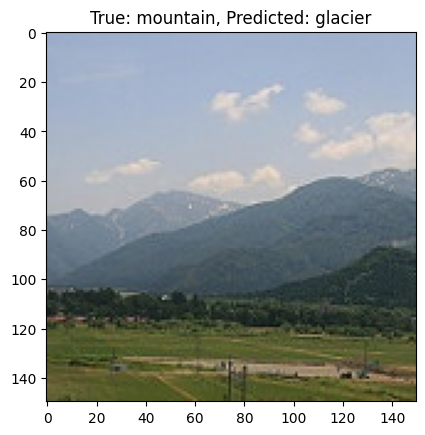

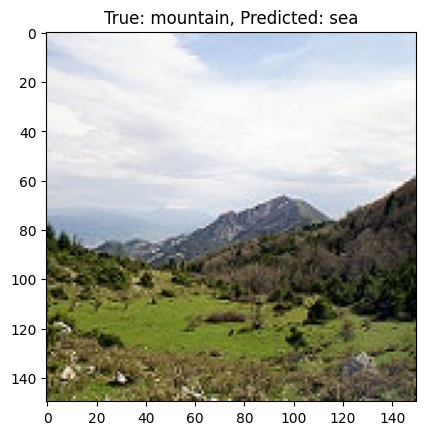

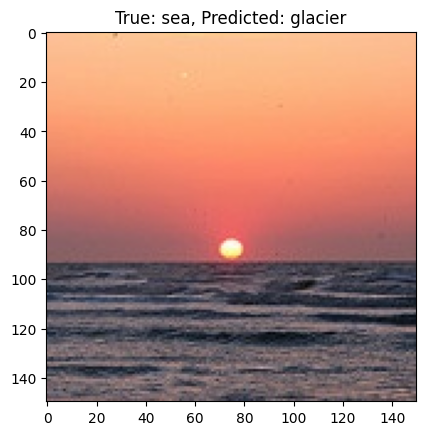

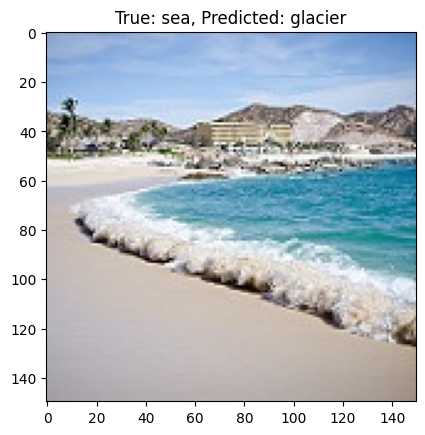

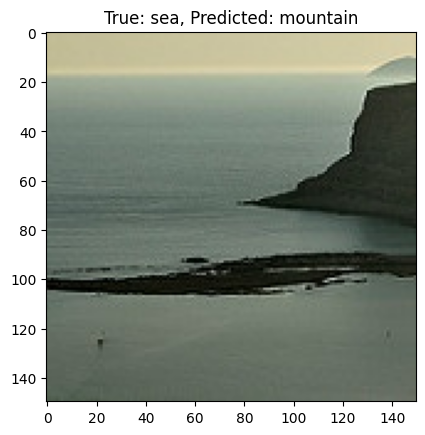

In [39]:
count = 0
misclassified_images_per_class = {i: 0 for i in range(6)}

# Iterate through the true and predicted labels to find misclassified images
for i, (true_label, predicted_label) in enumerate(zip(true_class_indices, predicted_class_indices)):
    if count < 15:
        if true_label != predicted_label:
            if misclassified_images_per_class[true_label] < 3:
                count += 1
                misclassified_images_per_class[true_label] += 1
                image_path = os.path.join(test_dir, class_names[true_label])
                image_list = os.listdir(image_path)
                misclassified_image = cv2.imread(os.path.join(image_path, image_list[misclassified_images_per_class[true_label] - 1]))
                misclassified_image_path = os.path.join(test_dir, f'misclassified_{i}.jpg')
                cv2.imwrite(misclassified_image_path, misclassified_image)

                # Display the misclassified image
                plt.imshow(cv2.cvtColor(misclassified_image, cv2.COLOR_BGR2RGB))
                plt.title(f'True: {class_names[true_label]}, Predicted: {class_names[predicted_label]}')
                plt.show()